# Variance-bounded state-space visualization

## Getting started

If you're not familiar with `python`, I'd start by downloading and installing `anaconda` from https://www.anaconda.com/. Then open up the terminal and create a new `conda` environment: this will give you a playground to install packages in and make sure everything is nice and easy. To do this, use the command

`conda create --name spring2025`

or you can call it whatever you like. Then activate the environment with

`conda activate spring2025`

I like using `pip` to install software so install `pip` first:

`conda install pip`

Then install our libraries:

`pip install numpy scipy jax matplotlib jupyter ipympl`

We'll use `numpy` for linear algebra, `scipy` for optimization and more, `jax` for just-in-time compiling and taking derivatives of functions in order to optimize efficiently, `matplotlib` to visualize things, `jupyter` so we can use notebooks such as this one, and finally `ipympl` so we can have interactive matplotlib widgets in notebooks.

Finally, navigate in the terminal to the directory in which you've saved this file, and run

`jupyter notebook`

A browser window should open up and you should see this document!

In [2]:
import numpy as np
import scipy as sc
from scipy.spatial import ConvexHull

import jax
import jax.numpy as jp
from jax import config
config.update("jax_enable_x64", True)

import matplotlib.pyplot as plt
np.set_printoptions(precision=3, suppress=True)

## Generating $P(E_i|\sigma_j)$

As explained in my *Spring 2025 Research Questions*, the theories we'll be investigated depend upon a special conditional probability matrix $P$ which must satisfy some basic constraints. So first off, we're going to have to find a way of randomly generating suitable $P$'s in order to play around with them.

A good $P$ matrix is defined by three parameters:

1. $n$: $P\in \mathbb{R}^{n\times n}$. Ultimately, the number of reference outcomes.
2. $r$: the rank of $P$.
3. $\alpha$: inverse depolarizing parameter.

As explained in the notes, in terms of these paramters, we can define
1. $\beta = \frac{1-\alpha}{n}$.
2. The Born matrix $\Phi = \alpha I + \beta J$, where $J$ is the matrix of all 1's.
2. $\gamma = \frac{n}{1 + \alpha^{-1}(r-1)}$.


We require of $P$:
1. $\forall i,j: P_{ij} \ge 0$ (non-negativity).
2. $\sum_i P_{ij} = \sum_j P_{ij} = 1$ (bistochastic).
3. $P = P^T$: (symmetric).
4. $\forall i: P(E_i|\sigma_i) = \gamma^{-1}$ (fixed-diagonal).
5. $P \Phi P = P$ (1-inverse).

So how are we going to implement these constraints?

Since $P$ ought to be symmetric, we can write it in terms of a spectral decomposition $P = \sum_{i=0}^{n-1} \lambda_i v_i v_i^T$ where $\{\lambda_i\}, \{v_i\}$ are the eigenvalues and eigenvectors of $P$ respectively. Note: to make things easy to import into python we index from 0. Let $u=(1,\dots,1)^T$ be the column vector of all 1's. Since $P$ must be bistochastic, $u$ must be an eigenvector with eigenvalue $1$. In fact, we should normalize it so it has length 1: $\frac{1}{\sqrt{n}}u$. Now we know from the notes that if $P$ is rank-$r$, the next $r-1$ eigenvectors must have eigenvalue $\alpha^{-1}$, and the remaining (which we don't have to worry about) have eigenvalue $0$. These eigenvectors must all be orthogonal to each other. 

How can we efficiently represent this? Let $O\in \mathbb{R}^{n\times r}$ be the matrix whose columns are the eigenvectors with non-zero eigenvalues of $P$. We assume the first column is $\frac{1}{\sqrt{n}}u$. Let $D\in \mathbb{R}^{r\times r}$ be the diagonal matrix whose diagonal has a single $1$ followed by $\alpha^{-1}$ repeated $r-1$ times. Then we can equivalently write $ P = O D O^T $. Demanding orthogonality means that we require $O^T O = I$. If we further demand that $\forall i,j: P_{ij}\ge0$, then we have a rank-$r$ symmetric, bistochastic matrix which because of its eigenstructure will satisfy $P\Phi P= P$.

But we also need the elements along the diagonal of $P$ to be constant. To analyze this constraint, let's re-write our spectral decomposition
$$ P = \frac{1}{n}u u^T + \alpha^{-1}\sum_{i=1}^{r-1} v_i v_i^T. $$
Denoting the $k$'th basis vector $e_k$, the diagonal elements are
$$ e_k^T P e_k = \frac{1}{n}e_k^T u u^T e_k + \alpha^{-1}\sum_{i=1}^{r-1} e_k^T v_i v_i^T e_k = \frac{1}{n} + \alpha^{-1}\sum_{i=1}^{r-1} O_{ki}^2. $$
If we demand this is equal to $\gamma^{-1}$, we have $\frac{1 + \alpha^{-1}(r-1)}{n} = \frac{1}{n} + \alpha^{-1}\sum_{i=1}^{r-1} O_{ki}^2$, or
$$\forall k: \sum_{i=1}^{r-1} O_{ki}^2=\frac{r-1}{n}.$$
In other words, the norms of the vectors formed from the rows $O$, where we drop the first index, must be fixed. 

The following code defines these three constraints and uses `scipy.optimize.minimize` to implement them.

In [22]:
n, r, alpha = 4, 3, 3

beta = (1-alpha)/n
gamma = n/(1 + (r-1)/alpha)

u, J = np.ones(n), np.ones((n,n))
Phi = alpha*np.eye(n) + beta*J
D = np.diag([1] + (r-1)*[1/alpha])

# We're going to minimize the following objective function. 
# By construction, we have symmetry, eigenstructure, and at least quasi-stochasticity already.
# Our three constraints are: orthogonality, fixed diagonal, and non-negativity.  
@jax.jit
def obj1(V):
    O = jp.hstack([jp.ones((n,1))/jp.sqrt(n), V.reshape(n,r-1)])
    return jp.linalg.norm(O.T @ O - jp.eye(r)) +\
           jp.linalg.norm(jp.diag(O[:, 1:] @ O[:,1:].T) - jp.ones(n)*(r-1)/n) +\
           (jp.sum(O @ D @ O.T) - jp.sum(abs(O @ D @ O.T)))**2

result = sc.optimize.minimize(obj1, np.random.randn(n*(r-1)),\
                            jac=jax.jit(jax.jacrev(obj1)),\
                            #method="SLSQP",\
                            tol=1e-16, options={"disp": True, "maxiter": 10000})
O = jp.hstack([jp.ones((n,1))/jp.sqrt(n), result.x.reshape(n,r-1)]);
P = np.array(O @ D @ O.T); P

         Current function value: 0.000000
         Iterations: 115
         Function evaluations: 167
         Gradient evaluations: 164


/Users/heyredhat/opt/anaconda3/envs/spring2025/lib/python3.12/site-packages/scipy/optimize/_minimize.py:733: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


array([[0.417, 0.25 , 0.083, 0.25 ],
       [0.25 , 0.417, 0.25 , 0.083],
       [0.083, 0.25 , 0.417, 0.25 ],
       [0.25 , 0.083, 0.25 , 0.417]])

Let's check out constraints are satisfied:

In [23]:
np.all(P >= 0),\
np.allclose(u @ P, u),\
np.allclose(P @ u, u),\
np.allclose(P, P.T),\
np.allclose(np.diag(P), u/gamma),\
np.allclose(P @ Phi @ P, P),\
np.linalg.eigvals(P)

(np.True_,
 True,
 True,
 True,
 True,
 True,
 array([ 1.   ,  0.333, -0.   ,  0.333]))

## Generating valid probabilities

Our fundamental assumption which defines our state-space is that
$$
P(E|\rho) \text{ valid}	\Longleftrightarrow \forall x\in \text{col}(P): \sum_i x_i^2P(E_i|\rho)\ge \sum_{ijk} A_{ijk}x_ix_jP(E_k|\rho).
$$
This becomes 
$$
\forall x\in \text{col}(P): \sum_{ij}x_iB[\rho]_{ij}x_j \ge 0,
$$
if we let
$$
B[\rho]_{ij}= \sum_k \Big(\delta_{ij}\delta_{ik}-A_{ijk}\Big)P(E_k|\rho),
$$
or better yet, simply
$$
C[\rho] \ge 0,
$$
if we let $C[\rho] = P \Phi B[\rho] P \Phi$. In other words, $P(E|\rho)$ is valid iff $C[\rho]$ is positive-semidefinite.

It would be good to consider different choices of $A_{ijk}$, but for now let's stick to the choice that makes our theory as quantum-like as possible:
$$
A_{ijk} = 	\eta \Big(\delta_{ij}-\delta_{ik}-\delta_{jk}\ \Big).
$$
For simplicity, we'll take $\eta = -\frac{\beta}{\alpha+1}$: this can be derived by assuming an algebraic symmetry. We'll go with it at the moment to avoid another free parameter floating around.

With this estalished, we can then accumulate a list of valid probability-assignments by randomly generating probability vectors $P(E|\rho)$ and simply checking whether $C[\rho]\ge0$.

In [24]:
eta = -beta/(alpha+1)

delta = lambda i, j: 1 if i == j else 0
V = np.array([[[delta(i,j)*delta(i,k) for k in range(n)] for j in range(n)] for i in range(n)])
A = np.array([[[eta*(delta(i,j) - delta(i,k) - delta(j,k)) for k in range(n)] for j in range(n)] for i in range(n)])
B = lambda x: np.einsum("ijk, k", V-A, x)
C = lambda x: P @ Phi @ B(x) @ P @ Phi

def valid_probabilities(max_iter=1000):
    for i in range(max_iter):
        p = np.random.dirichlet(u)
        if np.all(np.linalg.eigvals(C(p)) >= 0):
            return p
    return u/n

p = valid_probabilities(); p

array([0.29 , 0.302, 0.269, 0.139])

### Visualize 3D probability vectors

This works for $n=3$. We generate some large number $m$ of valid probablity vectors, and scatter-plot them in blue, along with the vertices of the probability simplex in red, and the probability vectors defining the reference (columns of $P$) in green. Try adjusting the opacity (alpha) to your taste.

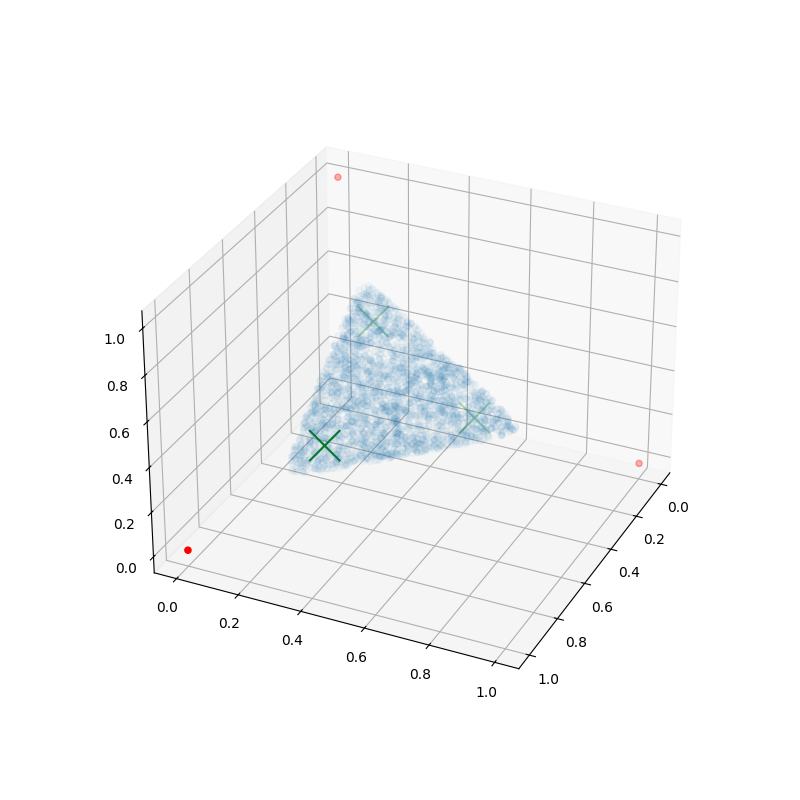

In [21]:
%matplotlib widget

m = 3000
valid_ps = np.array([valid_probabilities() for i in range(m)]).T
simplex = np.eye(3)

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(projection="3d")
ax.azim = 25

ax.scatter(*valid_ps, alpha=0.04)
ax.scatter(*simplex, c="r")
ax.scatter(*P, c="g", marker="x", s=500)

### Visualize 4D probability vectors

This works when $n=4$. In order to visualize this, we re-center the probability simplex around 0, and then embed into three dimensions. To implement this, we construct analysis and synthesis operators $F, F^T$. The idea is:
1. Re-center a probability vector around 0: $p_0 = p - \frac{1}{n}$.
2. Embed into 3D: $p^\prime = F p_0$.
3. Check that we can return: $F^T p^\prime + \frac{1}{n} = p$.

In [25]:
simplex0 = np.eye(n) - u/n
L, D, R = np.linalg.svd(simplex0)
F = R[:-1,:]
np.allclose(simplex0, F.T @ F)
np.allclose(p, F.T @ (F @ (p - u/n)) + u/n)

True

Then as above, we scatter-plot the valid probability vectors, the simplex vectors, and the reference probability vectors. Additionally, using `scipy`, we calculate the convex hull of the valid vector, and plot them in yellow.

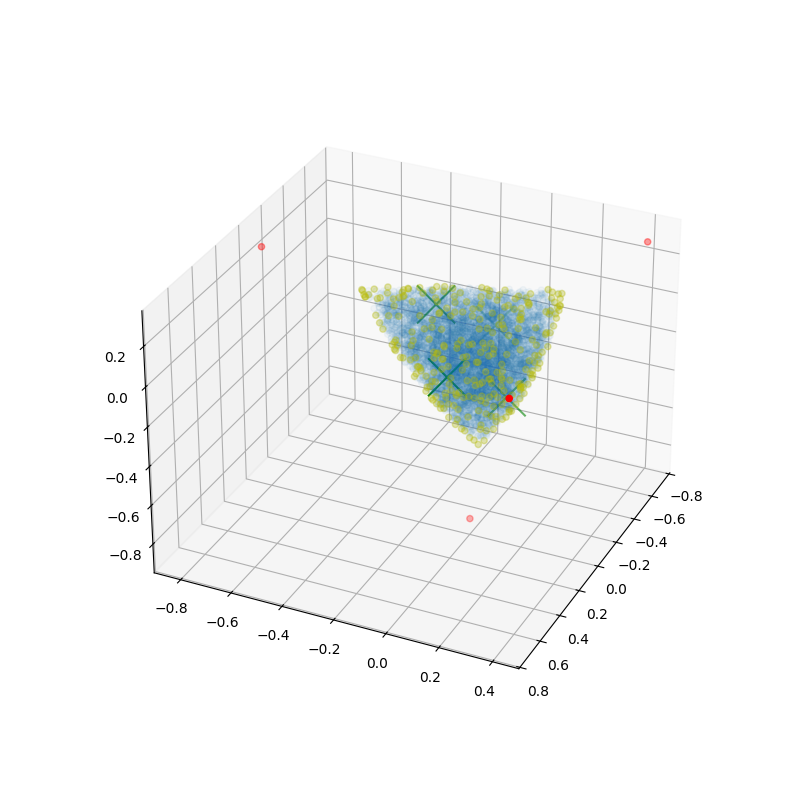

In [26]:
%matplotlib widget

m = 7000
valid_ps = np.array([valid_probabilities() for i in range(m)]).T
valid_ps_ = (F @ (valid_ps - np.ones(valid_ps.shape)/n))

hull = ConvexHull(valid_ps_.T)
hull_ps = valid_ps_.T[hull.vertices].T

simplex_ = (F @ (np.eye(n) - J/n))
P_ = (F @ (P - J/n))

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(projection="3d")
ax.azim = 25

ax.scatter(*valid_ps_, alpha=0.04)
ax.scatter(*hull_ps, alpha=0.3, c="y")
ax.scatter(*simplex_, c="r")
ax.scatter(*P_, c="g", marker="x", s=750)

## Check self-duality

Okay, visualizing things is nice, but we're limited by the dimension. We can also try to analyze the state-space. For example, does every valid state also correspond to a valid effect? In other words, do we have $\forall \rho, \tau: P(E|\tau) \Phi P(E|\rho) \ge 0$?

In [27]:
G = valid_ps.T @ Phi @ valid_ps
np.all(G >= 0)

np.False_

In [28]:
bad_guys = G < 0

In [29]:
G[bad_guys]

array([-0.018, -0.018, -0.04 , ..., -0.005, -0.001, -0.004],
      shape=(112168,))

In [30]:
np.mean([bad_guys])

np.float64(0.002289142857142857)

## Quantum 3-designs

Finally, for comparison, we can generate an actual quantum 3-design using similiar techniques, by minimizing the 3rd-order frame-potential. See if you can figure out what this code is doing!

In [32]:
d = 2 # 3
n = 6 # 27
t = 3

@jax.jit
def frame_potential(V):
    R = V[:d*n].reshape(d, n) + 1j*V[d*n:].reshape(d, n)
    R = R/jp.linalg.norm(R, axis=0)
    return (1/n**2)*jp.sum(abs(R.conj().T @ R)**(2*t))

result = sc.optimize.minimize(frame_potential, np.random.randn(2*d*n),\
                            jac=jax.jit(jax.jacrev(frame_potential)),\
                            tol=1e-26,\
                            options={"disp": True,\
                                    "maxiter": 10000})
V = result.x
R = V[:d*n].reshape(d, n) + 1j*V[d*n:].reshape(d, n)
R = R/np.linalg.norm(R, axis=0)
S = [np.outer(r, r.conj()) for r in R.T] # 3-design density matrices
E = [(d/n)*e for e in S] # 3-design POVM elements
P = np.array([[(e@s).trace() for s in S] for e in E]).real
Phi = (d+1)*np.eye(n) - (d/n)*np.ones((n,n))
P

         Current function value: 0.250000
         Iterations: 41
         Function evaluations: 74
         Gradient evaluations: 62


/Users/heyredhat/opt/anaconda3/envs/spring2025/lib/python3.12/site-packages/scipy/optimize/_minimize.py:733: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


array([[ 0.333,  0.167,  0.   ,  0.167,  0.167,  0.167],
       [ 0.167,  0.333,  0.167, -0.   ,  0.167,  0.167],
       [-0.   ,  0.167,  0.333,  0.167,  0.167,  0.167],
       [ 0.167, -0.   ,  0.167,  0.333,  0.167,  0.167],
       [ 0.167,  0.167,  0.167,  0.167,  0.333,  0.   ],
       [ 0.167,  0.167,  0.167,  0.167,  0.   ,  0.333]])